<a href="https://colab.research.google.com/github/AlexeyProvorov/chest-x-ray-diagnosis/blob/main/ResNet50%2BNN_chest_xray_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Just an example of a ResNet50 + neural network from scratch for recognizing chest X-ray images. Binary classification.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models,optimizers,applications,regularizers
import matplotlib.pyplot as plt


In [ ]:
print('Num GPUs Availible', len(tf.config.experimental.list_physical_devices('GPU')))
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print('Please install GPU version of tf')


Num GPUs Availible 0
Please install GPU version of tf


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"leoprovorov","key":"febb590f48686589e6793b52e31c4140"}'}

In [ ]:
%%capture
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:47<00:00, 89.7MB/s]
100% 2.29G/2.29G [00:47<00:00, 52.3MB/s]


In [ ]:
%%capture
!unzip chest-xray-pneumonia.zip -d chest_xray
data_dir = 'chest_xray/chest_xray'


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.Lambda(lambda x: tf.image.random_brightness(x, max_delta=0.1)),
    layers.Lambda(lambda x: tf.image.random_contrast(x, lower=0.9, upper=1.1)),
    layers.experimental.preprocessing.RandomWidth(0.1),
    layers.experimental.preprocessing.RandomHeight(0.1),
    layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
    layers.experimental.preprocessing.RandomCrop(256, 256)
])



In [ ]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/train',
    image_size=(256, 256),
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/val',
    image_size=(256, 256),
    batch_size=32
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/test',
    image_size=(256, 256),
    batch_size=32
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:
# Стандартизация данных
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Загрузка предобученной модели ResNet50 без верхних слоев
base_model = applications.ResNet50(input_shape=(256, 256, 3),
                                   include_top=False,
                                   weights='imagenet')

base_model.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, kernel_initializer=tf.keras.initializers.HeNormal()),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.01),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.build((None, 256, 256, 3))

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:

model.summary()

# Обучение модели
history = model.fit(
    normalized_train_ds,
    validation_data=normalized_val_ds,
    epochs=20  # Увеличение количества эпох для улучшения обучения
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)              

20/20 - 9s - loss: 1.5079 - accuracy: 0.6458 - 9s/epoch - 470ms/step

Тестовая точность: 0.6458333134651184


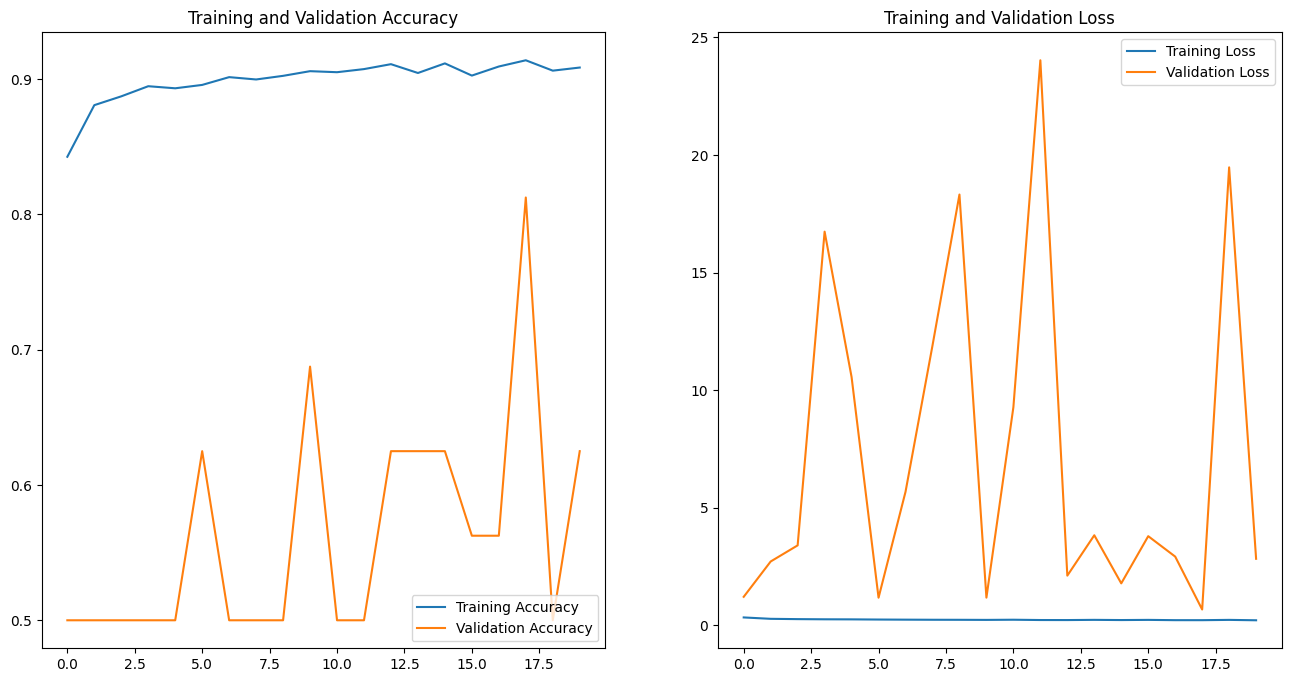

20/20 [==============================] - 6s 159ms/step


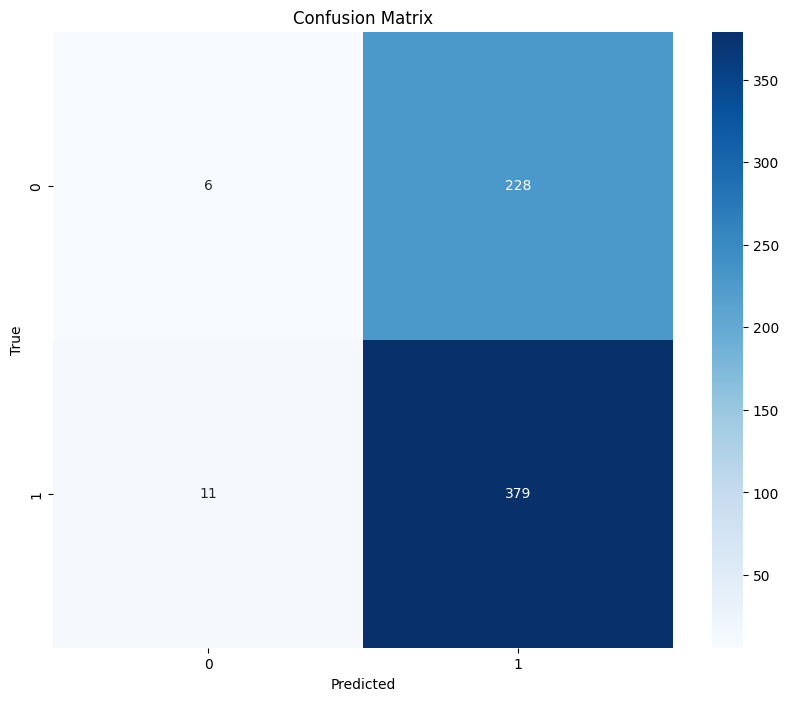

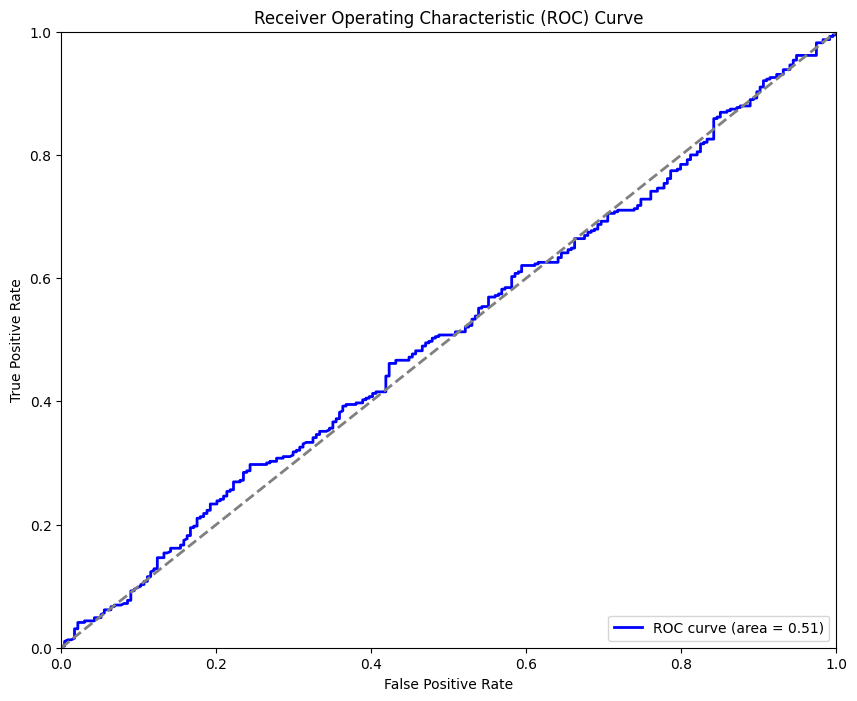

AUC: 0.51


In [ ]:
# Оценка модели
test_loss, test_acc = model.evaluate(normalized_test_ds, verbose=2)
print(f'\nТестовая точность: {test_acc}')

# График точности и потерь обучения
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# Построение матрицы ошибок (confusion matrix)
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Получение предсказаний на тестовом наборе данных
y_pred = model.predict(normalized_test_ds)
y_pred_classes = np.where(y_pred > 0.5, 1, 0)

# Получение истинных значений классов
y_true = np.concatenate([y for x, y in normalized_test_ds], axis=0)

# Построение матрицы ошибок
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Построение ROC-кривой и расчёт AUC
from sklearn.metrics import roc_curve, auc

# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f'AUC: {roc_auc:.2f}')

In [ ]:
# Пример настройки размера батча
batch_sizes = [16, 32, 64, 128]

for batch_size in batch_sizes:
    print(f'Training with batch size: {batch_size}')
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir + '/train',
        image_size=(256, 256),
        batch_size=batch_size
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir + '/val',
        image_size=(256, 256),
        batch_size=batch_size
    )

    normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

    model = models.Sequential([
        data_augmentation,
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, kernel_initializer=tf.keras.initializers.HeNormal(),
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        normalized_train_ds,
        validation_data=normalized_val_ds,
        epochs=5
    )

    test_loss, test_acc = model.evaluate(normalized_test_ds, verbose=2)
    print(f'Test accuracy with batch size {batch_size}: {test_acc}\n')